Files all have 3 columns of labels (indices are hard coded).

This file uses voting to reduce noise. Currently, voting by row (best out of 3 labels) is working and is the default used. Voting by sample (best out of 9 labels) has problems with incomplete data; right now it just prints out info about incomplete samples.

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from collections import defaultdict

MAX_FILES=4

In [2]:
def get_data(filename):
    csvfile = open(filename)
    reader = csv.reader(csvfile)

    data = []
    for i, row in enumerate(reader):
        if i == 0:
            headers = row
        else:
            data.append(row)
    csvfile.close()
    return headers, data

# Get stats

Run these cells in order to:
* get stats for ontopicness and fluency to copy/paste
* save percents for each topic for plotting

## topics

In [3]:
# for topics
def decode(st):
    ints = [int(s) for s in st.split('_')]
    # Version 2
    ii, j1, j2 = ints[0], np.mod(ints[1], MAX_FILES), np.mod(ints[2], MAX_FILES)
    return ii, j1, j2

# p-value of two binomial distributions
# one sided tail
def two_samp(x1, x2, n1, n2):
    p1 = x1/n1
    p2 = x2/n2
    phat = (x1 + x2) / (n1 + n2)
    z = (p1 - p2) / np.sqrt(phat * (1-phat) * (1/n1 + 1/n2))
    return stats.norm.sf(np.abs(z))

def print_info_t(scores, counts):
    percs = scores / counts
    print('total counts, on topic counts, percentages:')
    for i in range(MAX_FILES):
        print('{},{},{}'.format(counts[i], scores[i], percs[i]))

    pvalues = np.zeros((MAX_FILES, MAX_FILES))
    for i in range(MAX_FILES):
        for j in range(i, MAX_FILES):
            dist_i = [1] * scores[i] + [0] * (counts[i] - scores[i])
            dist_j = [1] * scores[j] + [0] * (counts[j] - scores[j])
            pvalue = two_samp(scores[i], scores[j], counts[i], counts[j])
            pvalues[i, j] = pvalue
            pvalues[j, i] = pvalue
    for row in pvalues:
        print('{:.8f},{:.8f},{:.8f},{:.8f}'.format(row[0],row[1],row[2],row[3]))

def get_counts_indices(data, order_index, label_indices):
    scores = np.zeros(MAX_FILES, dtype=int)
    counts = np.zeros(MAX_FILES, dtype=int)
    skipped = 0
    for rownum, row in enumerate(data):
        order = row[order_index]
        for label_index in label_indices:
            label = row[label_index].lower()
            if len(order) > 0 and len(label) > 0:
                a_cat, b_cat = decode(order)[1:]
                # print(label, order, a_cat, b_cat)
                if label == 'a' or label == 'both':
                    scores[a_cat] += 1
                if label == 'b' or label == 'both':
                    scores[b_cat] += 1
                counts[a_cat] += 1
                counts[b_cat] += 1
                if label not in ['a', 'b', 'both', 'neither']:
                    print('******invalid label: {}'.format(label))
            else:
                # print('empty label; skipping', rownum)
                skipped += 1
    print('skipped {}'.format(skipped))
    print_info_t(scores, counts)
    return scores, counts

# vote by row. each row contributes to one count (and 0 or 1 score based on majority vote)
def get_counts_vote_row(data, order_index, label_indices):
    scores = np.zeros(MAX_FILES, dtype=int)
    counts = np.zeros(MAX_FILES, dtype=int)
    skipped = 0
    for rownum, row in enumerate(data):
        order = row[order_index]
        if len(order) == 0:
            skipped += 1
        else:
            a_cat, b_cat = decode(order)[1:]
            row_score_a, row_score_b, row_counts = 0, 0, 0
            for label_index in label_indices:
                label = row[label_index].lower()
                if len(label) > 0:
                    if label == 'a' or label == 'both':
                        row_score_a += 1
                    if label == 'b' or label == 'both':
                        row_score_b += 1
                    row_counts += 1
                    if label not in ['a', 'b', 'both', 'neither']:
                        print('******invalid label: {}'.format(label))
                else:
                    print('empty label for nonempty prompt', rownum)
            # update big points
            if row_counts == 3:
                scores[a_cat] += row_score_a // 2
                scores[b_cat] += row_score_b // 2
                counts[a_cat] += 1
                counts[b_cat] += 1
            else:
                print('incomplete row...')
    print('skipped {}'.format(skipped))
    print_info_t(scores, counts)
    return scores, counts

# vote by sample. each sample contributes to one count (and 0 or 1 score based on majority vote)
# each sample should appear 9 times
def get_counts_vote_all(data, order_index, label_indices):
    samples = defaultdict(list) # key = (sample string, category), value = votes (list of 9)
    skipped = 0
    for rownum, row in enumerate(data):
        order = row[order_index]
        if len(order) == 0:
            skipped += 1
        else:
            a_cat, b_cat = decode(order)[1:]
            sample_a, sample_b = row[0], row[1]
            for label_index in label_indices:
                label = row[label_index].lower()
                if len(label) > 0:
                    if label == 'a':
                        samples[(sample_a, a_cat)].append(1)
                        samples[(sample_b, b_cat)].append(0)
                    elif label == 'b':
                        samples[(sample_a, a_cat)].append(0)
                        samples[(sample_b, b_cat)].append(1)
                    elif label == 'both':
                        samples[(sample_a, a_cat)].append(1)
                        samples[(sample_b, b_cat)].append(1)
                    elif label == 'neither':
                        samples[(sample_a, a_cat)].append(0)
                        samples[(sample_b, b_cat)].append(0)
                    else:
                        print('******invalid label: {}'.format(label))
                else:
                    print('empty label for nonempty prompt', rownum)
    print('skipped {}'.format(skipped))
    dist = np.zeros((MAX_FILES, 10), dtype=int)
    for sample in samples:
        cat = sample[1]
        samp_scores = samples[sample]
        if len(samp_scores) != 9:
            print('something had {} votes'.format(len(samp_scores)))
            print(sample)
        dist[cat, np.array(samp_scores).sum()] += 1
    print(dist)
    scores = np.zeros(MAX_FILES, dtype=int)
    counts = np.zeros(MAX_FILES, dtype=int)
    #print_info_t(scores, counts)
    return scores, counts

## fluency

In [4]:
def print_info_f_lists(scorelist):
    print('mean, stdev, min, max, counts:')
    for i in range(MAX_FILES):
        print('{},{},{},{},{}'.format(np.mean(scorelist[i]), np.std(scorelist[i]),
                                   np.min(scorelist[i]), np.max(scorelist[i]), len(scorelist[i])))

    pvalues = np.zeros((MAX_FILES, MAX_FILES))
    for i in range(MAX_FILES):
        for j in range(i, MAX_FILES):
            pvalue = stats.ttest_ind(scorelist[i], scorelist[j]).pvalue
            pvalues[i, j] = pvalue
            pvalues[j, i] = pvalue
    print('p-values')
    for row in pvalues:
        print('{:.8f},{:.8f},{:.8f},{:.8f}'.format(row[0],row[1],row[2],row[3]))

def get_fluencies_indices(data, order_index, label_indices):
    scorelist = [[], [], [], []]
    skipped = 0
    for r, row in enumerate(data):
        order = row[order_index]
        if len(order) == 0:
            continue
        for label_ind_pair in label_indices:
            a_cat, b_cat = decode(order)[1:]
            cats = decode(order)[1:]
            for i, ind in enumerate(label_ind_pair):
                label = row[ind]
                if len(label) > 0:
                    scorelist[cats[i]].append(int(label))
                else:
                    skipped += 1
    print('skipped {}'.format(skipped))
    print_info_f_lists(scorelist)
    return scorelist

## Run on all files

In [7]:
# aggregated human labeled everything
dirname = 'pplm_labeled_csvs/'
# comment out any of the below if you don't want to include them in "all"
file_info = [
#     'computers.csv',
#     'legal.csv',
#     'military.csv',
#     'politics.csv',
#     'religion.csv',
#     'science.csv',
#     'space.csv',
     'negative.csv',
     'positive.csv',
#     'clickbait.csv'
]

In [8]:
# hardcoded indices
category_index = -1 # index of encoded seed and methods
topic_indices = [2, 6, 10]
fluency_indices = [(3,4), (7,8), (11,12)]

all_scores = np.zeros(MAX_FILES, dtype=int)
all_counts = np.zeros(MAX_FILES, dtype=int)
percs_ordered = np.zeros((len(file_info), MAX_FILES)) # percents saved in same order as file names
for i, fname in enumerate(file_info):
    filename = dirname + fname
    headers, data = get_data(filename)
    print(fname)
    scores, counts = get_counts_vote_row(data, category_index, topic_indices)
#     scores, counts = get_counts_vote_all(data, category_index, topic_indices) # voting out of 9
    all_scores += scores
    all_counts += counts
    percs_ordered[i] = 100 * scores / counts
    print()
print('all:')
print_info_t(all_scores, all_counts)
print('\n------------\n')

# uber labeled fluencies
all_fluencies = [[], [], [], []]
for fname in file_info:
    filename = dirname + fname
    headers, data = get_data(filename)
    print(fname)
    new_scores = get_fluencies_indices(data, category_index, fluency_indices)
    for i in range(len(all_fluencies)):
        all_fluencies[i].extend(new_scores[i])
    print()
print('all:')
print_info_f_lists(all_fluencies)
print('total counts')
for x in all_fluencies:
    print(len(x))
    
all_scores_hist = all_fluencies

negative.csv
skipped 718
total counts, on topic counts, percentages:
135,47,0.34814814814814815
135,51,0.37777777777777777
135,74,0.5481481481481482
135,98,0.725925925925926
0.50000000,0.30634075,0.00047632,0.00000000
0.30634075,0.50000000,0.00249884,0.00000000
0.00047632,0.00249884,0.50000000,0.00119276
0.00000000,0.00000000,0.00119276,0.50000000

positive.csv
skipped 7
total counts, on topic counts, percentages:
135,5,0.037037037037037035
135,56,0.4148148148148148
135,38,0.2814814814814815
135,101,0.7481481481481481
0.50000000,0.00000000,0.00000002,0.00000000
0.00000000,0.50000000,0.01073817,0.00000001
0.00000002,0.01073817,0.50000000,0.00000000
0.00000000,0.00000001,0.00000000,0.50000000

all:
total counts, on topic counts, percentages:
270,52,0.1925925925925926
270,107,0.3962962962962963
270,112,0.4148148148148148
270,199,0.737037037037037
0.50000000,0.00000010,0.00000001,0.00000000
0.00000010,0.50000000,0.33061336,0.00000000
0.00000001,0.33061336,0.50000000,0.00000000
0.00000000,0

# Plots

## bar charts for ontopicness

Run one of these two:

In [9]:
# bag of words topics
percs_ordered = np.array([[ 8.33333333, 57.77777778, 15.55555556, 64.44444444],
                        [ 6.70391061, 28.88888889, 11.17318436, 40.55555556],
                        [ 4.44444444, 18.88888889,  5.        , 27.22222222],
                        [20.        , 71.66666667, 35.55555556, 69.44444444],
                        [ 5.18518519, 56.94444444,  7.40740741, 54.16666667],
                        [24.44444444, 49.44444444, 28.88888889, 61.66666667],
                        [ 7.22222222, 46.66666667,  5.        , 45.        ]])

# ours, theirs
percs_wd = 100* np.array([[0.6, 0.4], # computers
                          [0.4333333333, 0.6333333333],   # legal
                          [0.35, 0.3333333333], # military
                          [0.3333333333, 0.35], # politics
                          [0.5166666667, 0.2833333333],# religion
                          [0.55, 0.4], # science
                          [0.5666666667,0.1], # space
                         ]) 
percs_ctrl = 100* np.array([[0.75, 0.35], # computers
                          [0.35, 0.25],   # legal
                          [0., 0.], # military
                          [0.35, 0.5], # politics
                          [0.6, 1],# religion
                          [0.75, 0.4], # science
                          [0., 0.], # space
                         ]) 

xlabels = ['Computers', 'Legal', 'Military', 'Politics', 'Religion', 'Science', 'Space']

In [10]:
# discriminator and BoW together
percs_ordered = np.array([[ 3.7037037 , 41.48148148, 28.14814815, 74.81481481], # positive
                         [34.81481481, 37.77777778, 54.81481481, 72.59259259], # negative
                         [36.2962963 , 33.33333333, 48.88888889, 60.74074074], # clickbait
                         [19.25925926, 39.62962963, 41.48148148, 73.7037037 ], # p+n
                         [24.9382716 , 37.5308642 , 43.95061728, 69.38271605], # p+n+c
                         [11.12026359, 46.89542484, 15.815486  , 51.71568627], # bag of words
                        ])
xlabels = ['Positive', 'Negative', 'Clickbait', 'All sentiments', 
           'All discriminators', 'All bag of words']

Then run this:

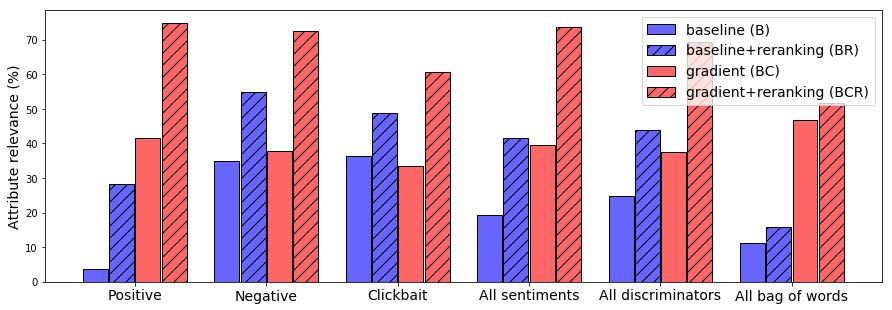

In [11]:
########## change params here to make chart look nicer
bar_width = 0.19 # width of bar itself
padded_width = 0.2 # width of bar + spacing
method_labels = ['baseline (B)', 'gradient (BC)', 'baseline+reranking (BR)', 'gradient+reranking (BCR)']
basecolor, gradcolor = (0.4, 0.4, 1.0), (1.0, 0.4, 0.4) # color represents gradient or no gradient
basehatch, rerankhatch = '', '//' # hatch represents reranking or no reranking
plt.figure(figsize=(15, 5))
swap_grad_rerank = True # True if you want to swap the order to [baseline, rerank, grad, both]
##########

colors = [basecolor, gradcolor, basecolor, gradcolor]
hatches = [basehatch, basehatch, rerankhatch, rerankhatch]
middle_xs = np.arange(len(xlabels)) - 1.5 * padded_width # location of tick bars
values_to_plot = [0, 2, 1, 3] if swap_grad_rerank else [0, 1, 2, 3]

for i in range(MAX_FILES):
    ind = values_to_plot[i] # use i for x position, ind for getting values and labels
    plt.bar(middle_xs + padded_width * i, percs_ordered[:, ind], width=bar_width,
            label=method_labels[ind], color=colors[ind], hatch=hatches[ind], ec='black')
    
# plt.bar(middle_xs + padded_width * (i+1), percs_wd[:, 1], width=bar_width,
#         label='weighted decoding', color=(0.4, 0.5, 0.4), ec='black')

# plt.bar(middle_xs + padded_width * (i+2), percs_ctrl[:, 1], width=bar_width,
#         label='CTRL', color=(0.4, 0.8, 0.4), ec='black')


plt.xticks(np.arange(len(xlabels)), labels=xlabels, fontsize=14)
plt.ylabel('Attribute relevance (%)', fontsize=14)
#plt.legend(loc=(0.8,0.7), fontsize=16)
plt.legend(fontsize=14)


# plt.figure(figsize=(15, 5))

# #plt.savefig('figures/bar_topics.pdf')
# baselinecolor, ourscolor = (0.4, 0.8, 0.4), (1.0, 1.0, 1.0)
# colors = [ourscolor, baselinecolor]
# method_labels = ['Ours (BCR)', 'WD']

# #plt.figure(figsize=(15, 5))
# for ii in range(MAX_FILES,MAX_FILES+2):
#     i = ii - MAX_FILES
#     plt.bar(middle_xs + padded_width * ii, percs_wd[:, i], width=bar_width,
#             label=method_labels[i], color=colors[i], ec='black')
# plt.xticks(np.arange(len(xlabels)), labels=xlabels)
# plt.ylabel('percent on topic')
# plt.legend()

#plt.savefig('figures/bar_discrim.pdf')

plt.show()


#### histograms for human labeled fluencies

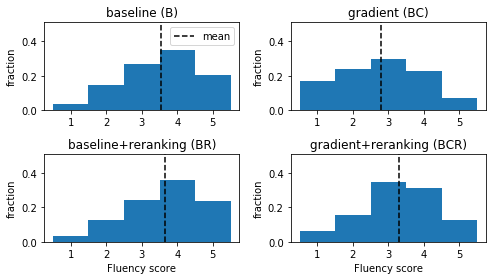

In [12]:
# histograms for human labeled fluencies
titles = ['baseline (B)', 'gradient (BC)', 'baseline+reranking (BR)', 'gradient+reranking (BCR)']
plt.figure(figsize=(7, 4))
for cat in range(4):
    plt.subplot(2, 2, cat+1)
    plt.hist(all_scores_hist[cat], bins=0.5 + np.arange(0, 6), rwidth=1, density=True)
    plt.axvline(np.mean(all_scores_hist[cat]), c='k', linestyle='--', label='mean')
    plt.ylabel('fraction')
    plt.ylim([0, 0.51]) # this is hardcoded. adjust as needed
    #if cat < 3:
    #    plt.xticks(range(1, 6), ['' for _ in range(5)])
    plt.xticks(range(1, 6), [_+1 for _ in range(5)])
    if cat > 1:
        plt.xlabel('Fluency score')
    plt.title(titles[cat])
    if cat == 0:
        plt.legend()
plt.tight_layout()
#plt.gcf().subplots_adjust(bottom=0.08)
#plt.xlabel('fluency score')
#plt.savefig('figures/fluency_sentiments.pdf')
plt.show()